<a href="https://colab.research.google.com/github/pmvdafonseca/filter_fir_high_pass/blob/main/Projeto_FIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto de um filtro FIR**

Estudo de filtros FIR passa-banda através de um projeto com as seguintes características:

Fase: Linear

Ripple da banda de passagem: 0.1dB

Atenuação mínima da banda de passagem: 60 dB

Taxa de amostragem: 44.1kHz

In [23]:
# Projeto de um filtro FIR passa baixa
import numpy as np
from scipy import signal
from scipy import special
import matplotlib.pyplot as plt
from IPython.display import Audio 
import math
from numpy import sin, cos, pi

In [24]:
# fp = 15750         # frequência superior da banda de passagem
# fr = 15500       # frequência inferior da banda de rejeição
fs = 44100        # frequência de amostragem
alphap = 0.1      # ripple admissível na banda de passagem em dB
alphar = 60       # atenuação mínima na banda de rejeição (ripple) em dB
theta_l = 15800
theta_u = 16200

Algumas transformações necessárias nas variáveis de entrada:


*   Transformações dos ripples em escala linear
$$\delta_p = 1 - 10^{-\frac{\alpha_p}{20}}$$
$$\delta_r = 10^{-\frac{\alpha_r}{20}}$$

*   Transformação das frequências em frequências normalizadas


$$\omega_p = 2\pi \frac{f_p}{f_s}$$
$$\omega_r = 2\pi \frac{f_r}{f_s}$$

In [25]:
deltap = 1 - 10**(-alphap/20.0)  # ripple na banda de passagem (escala linear)
deltar = 10**(-alphar/20.0)      # atenuação mínima na banda de rejeição (escala linear)
omegap = 2*np.pi*theta_l/fs           # frequência superior da banda de passagem normalizada entre zero e pi
omegar = 2*np.pi*theta_u/fs           # frequência inferior da banda de rejeição normalizada entre zero e pi
print(deltar)
print(deltap)
print(omegap)
print(omegar)

0.001
0.011446905343061142
0.0071237928652829775
0.042742757191697865


Estimativa de ordem segundo a Fórmula de Kaiser
$$N \approx \frac{-20 log_{10}(\sqrt{\delta_p \delta_s})-13}{14.6 \frac{\omega_s - \omega_p}{2\pi}}$$

In [26]:
# Estimativa de ordem com a fórmula de Kaiser
Nkaiser = np.ceil((-20.0*np.log10(np.sqrt(deltap*deltar)) -13.0)/(14.6*(omegar - omegap)/(2.0*np.pi)))
print ('Estimativa com a fórmula de Kaiser: ' + str(Nkaiser))

Estimativa com a fórmula de Kaiser: 440.0


Estimativa de ordem segundo a Fórmula de Bellanger
$$N \approx -\frac{2 \log_{10} (10 \delta_p \delta_s)}{3 \frac{\omega_s - \omega_p}{2\pi}} -1$$

In [27]:
# Estimativa de ordem com a fórmula de Bellanger
Nbellanger = np.ceil(-(2.0*np.log10(10.0*deltap*deltar))/(3.0*((omegar-omegap)/(2.0*np.pi))) -1.0)
print ('Estimativa com a fórmula de Bellanger: ' + str(Nbellanger))

Estimativa com a fórmula de Bellanger: 463.0


Estimativa de ordem segundo a Fórmula de Herrmann
$$N \approx \frac{D_\infty(\delta_p,\delta_s) - F(\delta_p,\delta_s)\left[\frac{\omega_p-\omega_s}{2\pi}\right]^2}{\frac{\omega_p-\omega_s}{2\pi}}$$
em que 
$$D_\infty (\delta_p,\delta_s)  = \left[ a_1(\log_{10}\delta_p)^2 + a_2(\log_{10}\delta_p) + a_3  \right] \log_{10} \delta_s - \left[ a_4(\log_{10}\delta_p)^2 + a_5(\log_{10}\delta_p) + a_6  \right]$$
$$F(\delta_p,\delta_s) = b_1 + b_2 (\log_{10}\delta_p - \log_{10}\delta_s)$$
e
$$a_1 = 0.005309$$ $$a_2 = 0.07114$$ $$a_3 = -0.4761$$ $$a_4 = 0.00266$$  $$a_5 = 0.5941$$ $$a_6 = 0.4278$$ $$b_1 = 11.01217$$ $$b_2 = 0.51244$$

In [28]:
# Estimativa de ordem com a fórmula de Hermann

a1 = 0.005309
a2 = 0.07114
a3 = -0.4761
a4 = 0.00266
a5 = 0.5941
a6 = 0.4278
b1 = 11.01217
b2 = 0.51244

Dinf = (a1*(np.log10(deltap)**2.0) + a2*np.log10(deltap)+a3)*np.log10(deltar) -(a4*(np.log10(deltap)**2.0)+a5*np.log10(deltap) + a6)

F = b1 + b2*(np.log10(deltap) - np.log10(deltar))

Nherrmann = np.ceil((Dinf - F*(((omegap-omegar)/(2*np.pi))**2.0))/((omegar-omegap)/(2.0*np.pi)))
print ('Estimativa com a fórmula de Hermann: ' + str(Nherrmann))

Estimativa com a fórmula de Hermann: 441.0


Estimativa segundo a função kaiserord da biblioteca scipy.signal. A estimativa é realizada (acho) por meio da equação

$$N \approx \frac{-20\log_{10}(\min\{\delta_p,\delta_r\}) - 7.95}{ 2.285 \frac{ \omega_r - \omega_p }{2}} + 1$$

In [29]:
# Estimativa de ordem supondo uma janela de Kaiser, utilizando a função pronta do scipy.signal
ripple = min(deltap,deltar)
Nkaiserwin, beta = signal.kaiserord(-20*np.log10(ripple),(omegar-omegap)/(2.0*np.pi))
print ('Estimativa para uma janela de Kaiser: ' + str(Nkaiserwin))

Estimativa para uma janela de Kaiser: 1281


Especifica a resposta ao impulso de um filtro ideal passa-baixa com frequência de corte $\omega_c$
$$h_{\mathrm{ideal}}[n] = \frac{\omega_c}{\pi} \mathrm{sinc}\left[\frac{\omega_c}{\pi} \left(n-\frac{N-1}{2}\right)\right], \quad n=0,1,\ldots,N-1$$
em que $$\mathrm{sinc}(x) = \frac{\sin(\pi x)}{\pi x}$$

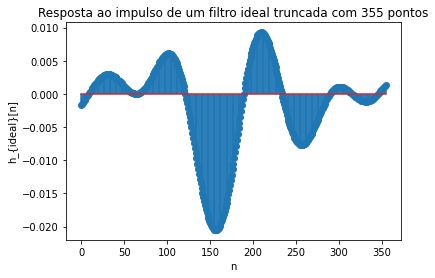

In [30]:
# Especifiquei um comprimento de filtro FIR a partir das estimativas anteriores mas não necessariamente usando elas
N = 355
n = np.arange(0,N,1)

theta_c =((theta_u - theta_l)/2)*(2.0*np.pi/fs)
theta_o = ((theta_u +theta_l)/2)*(2.0*np.pi/fs)

hideal = 2*cos(n*theta_o)*(theta_c*special.sinc((n-(N-1)/2.0)*theta_c))


plt.title('Resposta ao impulso de um filtro ideal truncada com '+str(N)+' pontos')
plt.xlabel('n')
plt.ylabel('h_{ideal}[n]')
plt.stem(n,hideal,use_line_collection=True)
plt.show()

Utiliza uma janela de Hamming
$$w[n] = 0.54 + 0.46\cos\left(\frac{2\pi \left(n - \frac{N-1}{2}\right)}{N}\right), \quad n=0,1,2,\ldots,N-1$$
multiplicada à resposta do filtro ideal para produzir o protótipo do filtro $h[n]$

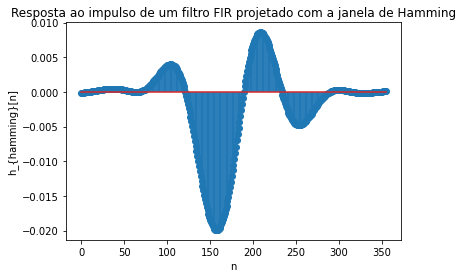

In [31]:
hwin = signal.windows.hamming(N)
hhamming = hwin*hideal
plt.title('Resposta ao impulso de um filtro FIR projetado com a janela de Hamming')
plt.xlabel('n')
plt.ylabel('h_{hamming}[n]')
plt.stem(n,hhamming,use_line_collection=True)
plt.show()

(0.0, 3.141592653589793, -80.0, 6.0)

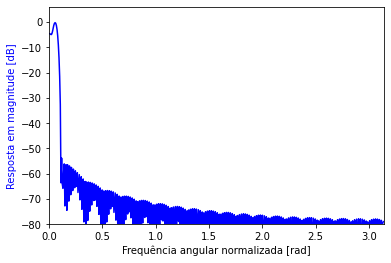

In [32]:
w,respfreq = signal.freqz(hhamming,1)
plt.plot(w, 20 * np.log10(abs(respfreq)), 'b')
plt.ylabel('Resposta em magnitude [dB]', color='b')
plt.xlabel('Frequência angular normalizada [rad]')
# plt.fill([0, omegap,  omegap,  0], [-alphap, -alphap, -600, -600], '0.5', lw=0) 
# plt.fill([0, omegap,  omegap,  0], [alphap, alphap, 600, 600], '0.5', lw=0) 
# plt.fill([omegar, omegar, np.pi, np.pi], [99,  -alphar,  -alphar, 99], '0.5', lw=0) 
plt.axis([0, np.pi, -80, 6])

(0.0, 22.05, -80.0, 6.0)

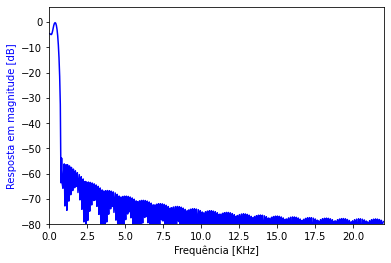

In [33]:
w,respfreq = signal.freqz(hhamming,1)
plt.plot((w/(2.0*np.pi/fs))/1000, 20 * np.log10(abs(respfreq)), 'b')
plt.ylabel('Resposta em magnitude [dB]', color='b')
plt.xlabel('Frequência [KHz]')
# plt.fill([0, omegap,  omegap,  0], [-alphap, -alphap, -600, -600], '0.5', lw=0)
# plt.fill([0, omegap,  omegap,  0], [alphap, alphap, 600, 600], '0.5', lw=0) 
# plt.fill([omegar, omegar, np.pi, np.pi], [99,  -alphar,  -alphar, 99], '0.5', lw=0) 
plt.axis([0, (np.pi/(2.0*np.pi/fs))/1000, -80, 6])

Repetindo o processo com uma janela de Kaiser

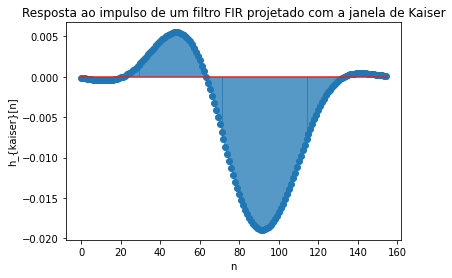

In [34]:
N = 155
n = np.arange(0,N,1)

hideal = 2*cos(n*theta_o)*(theta_c*special.sinc((n-(N-1)/2.0)*theta_c))

hwin = signal.windows.kaiser(N,beta)
hkaiser = hwin*hideal
plt.title('Resposta ao impulso de um filtro FIR projetado com a janela de Kaiser')
plt.xlabel('n')
plt.ylabel('h_{kaiser}[n]')
plt.stem(n,hkaiser,use_line_collection=True)
plt.show()

(0.0, 3.141592653589793, -80.0, 6.0)

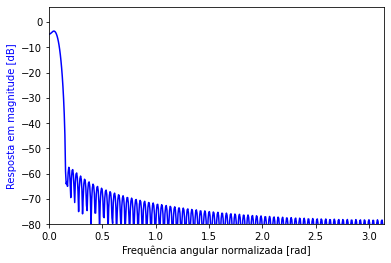

In [35]:
w,respfreq = signal.freqz(hkaiser,1)
plt.plot(w, 20 * np.log10(abs(respfreq)), 'b')
plt.ylabel('Resposta em magnitude [dB]', color='b')
plt.xlabel('Frequência angular normalizada [rad]')
# plt.fill([0, omegap,  omegap,  0], [-alphap, -alphap, -600, -600], '0.5', lw=0)
# plt.fill([0, omegap,  omegap,  0], [alphap, alphap, 600, 600], '0.5', lw=0) 
# plt.fill([omegar, omegar, np.pi, np.pi], [99,  -alphar,  -alphar, 99], '0.5', lw=0) 
plt.axis([0, np.pi, -80, 6])

(0.0, 22.05, -80.0, 6.0)

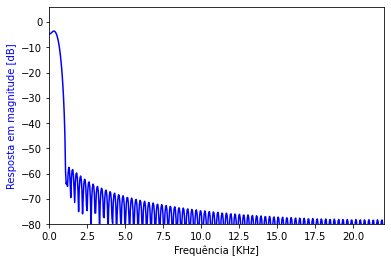

In [36]:
w,respfreq = signal.freqz(hkaiser,1)
plt.plot((w/(2.0*np.pi/fs))/1000, 20 * np.log10(abs(respfreq)), 'b')
plt.ylabel('Resposta em magnitude [dB]', color='b')
plt.xlabel('Frequência [KHz]')
# plt.fill([0, omegap,  omegap,  0], [-alphap, -alphap, -600, -600], '0.5', lw=0)
# plt.fill([0, omegap,  omegap,  0], [alphap, alphap, 600, 600], '0.5', lw=0) 
# plt.fill([omegar, omegar, np.pi, np.pi], [99,  -alphar,  -alphar, 99], '0.5', lw=0) 
plt.axis([0, (np.pi/(2.0*np.pi/fs))/1000, -80, 6])

Cria um sinal de entrada $$x[n] = \sin(2\pi \frac{440}{44100} n) + \sin(2\pi \frac{6000}{44100} n)$$ (uma senóide de 440 Hz na banda de passagem e uma senóide de 6000 Hz na banda de rejeição) para o teste do filtro

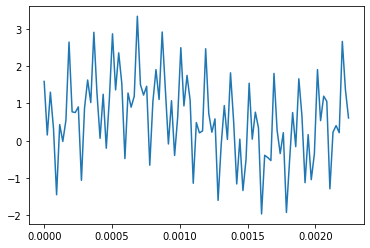

In [37]:
n = np.arange(0,2,1.0/fs)
x = np.sin(2*np.pi*100*n) + np.sin(2*np.pi*440*n) + np.sin(2*np.pi*6000*n)+ np.sin(2*np.pi*16000*n)
# x = np.sin(2*np.pi*16000*n)
plt.plot(np.linspace(0, (99)/fs, num=99), x[1:100])
Audio(x,rate=fs)

Filtra o sinal com o filtro FIR projetado com a janela de Hamming

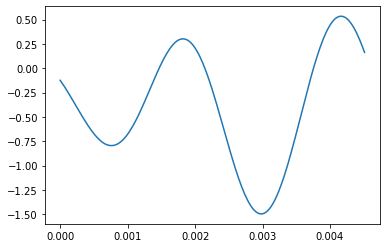

In [38]:
yhamming = signal.lfilter(hhamming,1,x)
plt.plot(np.linspace(0, (199)/fs, num=199), yhamming[151:350])
Audio(yhamming,rate=fs)

Filtra o sinal com o filtro FIR projetado com a janela de Kaiser

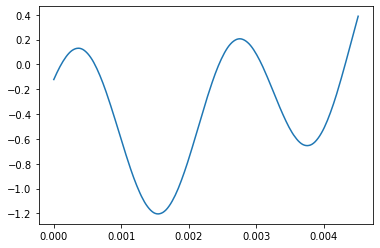

In [39]:
ykaiser = signal.lfilter(hkaiser,1,x)
plt.plot(np.linspace(0, (199)/fs, num=199), ykaiser[151:350])
Audio(ykaiser,rate=fs)